#**Protein Family Classification using ESM-2 Embeddings and XGBoost**


This project focuses on classifying protein sequences into their respective SCOPe families using state-of-the-art protein embeddings and machine learning techniques. We leverage the ESM-2 model, a transformer-based protein language model, to extract meaningful embeddings from amino acid sequences.: These embeddings serve as inputs to an XGBoost classifier trained to predict protein classes.



The workflow includes:

* Parsing and preprocessing protein sequence data from FASTA files.

* Extracting embeddings with the pretrained ESM-2 model (6-layer version).

* Training and evaluating different classifiers including XGBoost and neural networks.

* Visualizing embedding spaces and model performance metrics.

* Testing model robustness on a dataset with low sequence similarity (40% identity) to assess generalization.

The goal is to build an accurate and efficient classifier that can generalize well across diverse protein families, demonstrating the power of modern protein language models combined with scalable machine learning methods.

##Necessary Packages

In [1]:
!pip install biopython

In [2]:
!pip install fair-esm

In [ ]:
!pip install xgboost

In [3]:
from Bio import SeqIO
import pandas as pd
import torch
import esm
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
import psutil
import os
import time
import seaborn as sns
import gradio as gr


#Load and Parse Protein Sequences from FASTA File



In [ ]:
"""
This cell reads a FASTA file containing protein domain sequences and parses each record using Biopython's SeqIO. For every sequence record,
it prints the ID, full description, and the amino acid sequence.
This step is essential for inspecting and verifying the raw data before further processing.
"""
fasta_file = "/content/astral-scopedom-seqres-gd-sel-gs-bib-95-2.08.fa.txt"

for record in SeqIO.parse(fasta_file, "fasta"):


    print("ID:", record.id)
    print("Description:", record.description)
    print("Sequence:", record.seq)
    print("-----")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
ID: d1ff4a_
Description: d1ff4a_ g.7.1.1 (A:) Muscarinic toxin {Green mamba (Dendroaspis angusticeps) [TaxId: 8618]}
Sequence: ltcvttksiggvttedcpagqnvcfkrwhyvtpknydiikgcaatcpkvdnndpirccgtdkcnd
-----
ID: d1ntna_
Description: d1ntna_ g.7.1.1 (A:) Neurotoxin I {Snake (Naja naja oxiana) [TaxId: 8657]}
Sequence: itcyktpiitsetcapgqnlcytktwcdawcgsrgkvielgcaatcptvesyqdikccstdncnphpkqkrp
-----
ID: d1vb0a_
Description: d1vb0a_ g.7.1.1 (A:) Neurotoxin II (Nt2, cobrotoxin B) {Chinese cobra (Naja atra) [TaxId: 8656]}
Sequence: lechnqqssqtpttktcsgetncykkwwsdhrgtiiergcgcpkvkpgvnlnccttdrcnn
-----
ID: d1txba_
Description: d1txba_ g.7.1.1 (A:) Toxin B (long neurotoxin) {King cobra (Ophiophagus hannah) [TaxId: 8665]}
Sequence: tkcyvtpdatsqtcpdgqdicytktwcdgfcssrgkridlgcaatcpkvkpgvdikccstdncnpfptwkrkh
-----
ID: d1ug4a_
Description: d1ug4a_ g.7.1.1 (A:) automated matches {Chinese cobra (Naja atra) [TaxId: 8656]}
Sequence: lkcnqlip

#Extract and Structure Protein Sequence Metadata into DataFrame



In [ ]:
"""
This cell parses the FASTA file records to extract relevant metadata from the description field, such as the SCOPe class and family identifiers.
 It organizes these details along with the sequence and ID into a structured pandas DataFrame for easier analysis and processing.
"""

data = []

for record in SeqIO.parse(fasta_file, "fasta"):
    description = record.description
    # Example : "d1x3ha1 g.39.1.3 (A:8-42) Leupaxin {Human (Homo sapiens) [TaxId: 9606]}"

    parts = description.split()
    scop_label = parts[1]  # ex: 'g.39.1.3'
    scop_class = scop_label.split('.')[0]  # ex: 'g'
    scop_family = '.'.join(scop_label.split('.')[:3])  # ex: 'g.39.1.3'

    data.append({
        "ID": record.id,
        "Description": description,
        "Class": scop_class,
        "Family": scop_family,
        "Sequence": str(record.seq)
    })

df = pd.DataFrame(data)

df.head()

,ID,Description,Class,Family,Sequence
0,d1ux8a_,d1ux8a_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a,a.1.1,napyeaigeellsqlvdtfyervashpllkpifpsdltetarkqkq...
1,d1dlwa_,d1dlwa_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a,a.1.1,slfeqlggqaavqavtaqfyaniqadatvatffngidmpnqtnkta...
2,d1dlya_,d1dlya_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a,a.1.1,slfaklggreaveaavdkfynkivadptvstyfsntdmkvqrskqf...
3,d2gkma_,d2gkma_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a,a.1.1,gllsrlrkrepisiydkiggheaievvvedffvrvladdqlsaffs...
4,d1ngka_,d1ngka_ a.1.1.1 (A:) Protozoan/bacterial hemog...,a,a.1.1,ksfydavggaktfdaivsrfyaqvaedevlrrvypeddlagaeerl...


#Load Pretrained ESM-2 Model and Prepare Batch Converter

In [ ]:
"""
This cell loads the pretrained ESM-2 protein language model (6 layers, 8 million parameters) along with its alphabet tokenizer.
The model is set to evaluation mode,
 and the batch converter function is initialized to prepare protein sequences for embedding extraction.
"""
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()



Applying ESM-2 embeddings on the full dataset proved computationally expensive and time-consuming, requiring up to 7 hours with more powerful resources than currently available. To make the process feasible within our resource constraints, we randomly sampled 14% of the dataset (5,000 sequences) for further analysis and embedding extraction.

In [ ]:
df.shape

(35494, 5)

In [ ]:
df= df.sample(n=5000, random_state=42)

In [ ]:
df.shape

(5000, 5)

#Generate ESM-2 Embeddings for Protein Sequences


In [ ]:
"""
This code converts protein sequences to uppercase and processes them in batches to generate embeddings using the ESM-2 pretrained model (layer 6).
 The embeddings are computed efficiently using batching and stored back into the dataframe as a new column for further analysis or modeling.


"""


df['Sequence'] = df['Sequence'].str.upper()

sequences = list(zip(df['ID'], df['Sequence']))

batch_size = 8
all_embeddings = []

for i in tqdm(range(0, len(sequences), batch_size)):
    batch = sequences[i:i+batch_size]
    batch_labels, batch_strs, batch_tokens = batch_converter(batch)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=False)
    emb = results["representations"][6][:, 0, :].cpu()
    all_embeddings.append(emb)

all_embeddings = torch.cat(all_embeddings, dim=0)

df['ESM2_embedding'] = list(all_embeddings.numpy())


100%|██████████| 625/625 [29:54<00:00,  2.87s/it]


In [ ]:
df.head()

,ID,Description,Class,Family,Sequence,ESM2_embedding
11623,d1zlma_,d1zlma_ b.34.2.0 (A:) automated matches {Human...,b,b.34.2,GQVKVFRALYTFEPRTPDELYFEEGDIIYITDMSDTNWWKGTSKGR...,"[0.3664262, 0.9756233, 0.22260508, 0.19436628,..."
3874,d3n0fa1,d3n0fa1 a.102.4.0 (A:57-265) automated matches...,a,a.102.4,SADYEPNSWDYDFLLSSDTDESIEVYKDKAKKLEAEVRREINNEKA...,"[0.034898248, 0.55597824, 0.22316599, 0.262523..."
23972,d5ubia_,d5ubia_ c.94.1.0 (A:) automated matches {Campy...,c,c.94.1,NTRLRIAIQKSGRLSKESIELLSECGVKMHIHEQSLIAFSTNLPID...,"[0.21458669, 0.549833, 0.21130703, 0.13306451,..."
25387,d1ywxa1,d1ywxa1 d.12.1.3 (A:1-102) Ribosomal protein S...,d,d.12.1,MDISIISDRNNPLLQRREIKFTVSFDAATPSIKDVKMKLVAVLNAN...,"[0.11518017, 0.67958766, -0.007459573, 0.45693..."
31563,d1bcca1,d1bcca1 d.185.1.1 (A:4-232) Cytochrome bc1 cor...,d,d.185.1,YAQALQSVPETQVSQLDNGVRVASEQSSQPTCTVGVWIDAGSRYES...,"[0.14452274, 0.7092483, 0.36625823, 0.2417976,..."


In [ ]:
df["ESM2_embedding"].iloc[0]

array([ 3.66426200e-01,  9.75623310e-01,  2.22605079e-01,  1.94366276e-01,
        1.14030302e-01, -4.42319334e-01, -7.33444095e-01, -1.96356308e-02,
       -2.34080225e-01, -7.71840036e-01,  4.45969135e-01, -2.89661050e-01,
       -7.84785092e-01, -2.09985450e-01, -6.30957007e-01, -9.00494531e-02,
        4.54604566e-01, -2.56105177e-02,  1.32820860e-01, -4.10126030e-01,
       -1.64623242e-02, -2.22547993e-01,  1.28284186e-01,  2.35196277e-02,
       -3.32545370e-01,  3.21591049e-01,  1.29886568e-01,  1.31252274e-01,
        1.76197737e-02,  1.97983667e-01,  4.85511348e-02,  1.55997723e-01,
       -1.70360789e-01, -2.59114504e-01, -1.70392971e-02, -4.28701669e-01,
       -5.63137949e-01, -2.83106178e-01, -1.48182288e-01, -4.37929451e-01,
        6.13594651e-01,  2.79364824e-01, -2.12512508e-01, -1.26433566e-01,
        1.64117143e-01,  3.00350219e-01,  7.50611484e-01, -5.67536831e-01,
       -1.31756678e-01, -4.94472116e-01,  1.40503719e-01, -1.83325559e-01,
        3.58593404e-01, -

In [ ]:
import numpy as np

#Check Consistency of Embedding Shapes


In [ ]:
"""
This snippet verifies that all generated embeddings have the same shape by computing and counting the shapes of embeddings stored in the dataframe.
 It ensures data consistency before using embeddings for modeling or visualization.
"""
shapes = df['ESM2_embedding'].apply(lambda x: np.array(x).shape)
print(shapes.value_counts())

unique_shapes = shapes.unique()
if len(unique_shapes) == 1:
    print(f"Toutes les embeddings ont la même forme: {unique_shapes[0]}")
else:
    print(f"Attention, embeddings avec différentes formes détectées: {unique_shapes}")

ESM2_embedding
(320,)    5000
Name: count, dtype: int64
Toutes les embeddings ont la même forme: (320,)


#Visualize Protein Embeddings with t-SNE



/tmp/ipython-input-3917299322.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_classes))


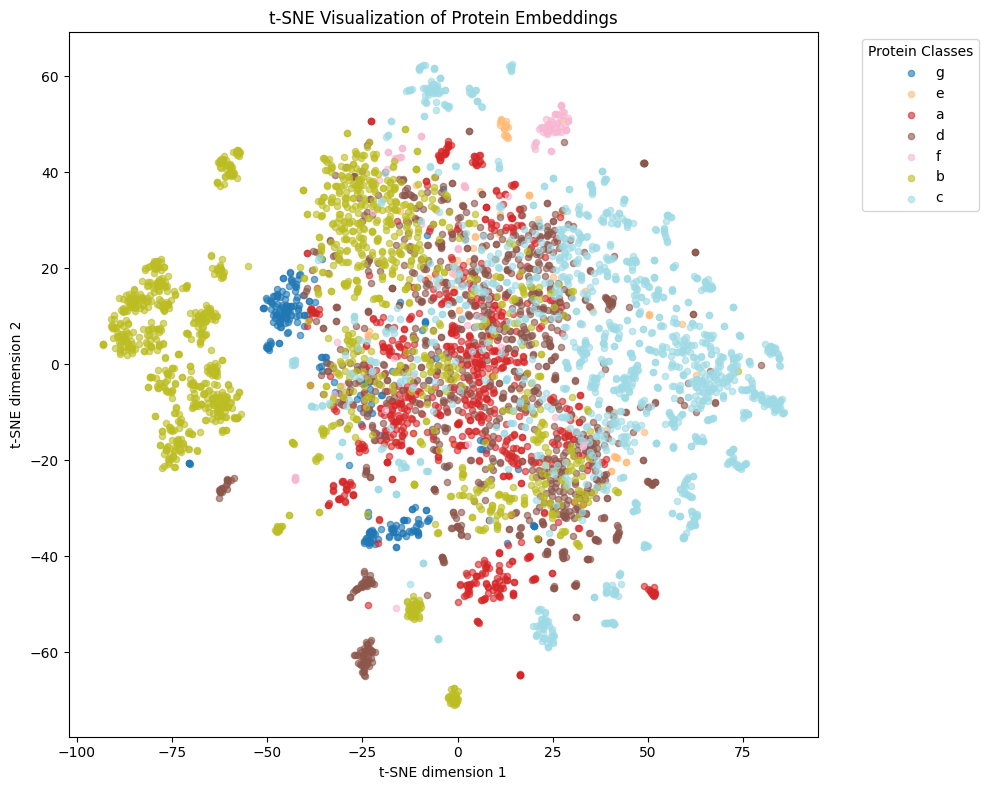

In [ ]:

"""
This code applies t-SNE to reduce the dimensionality of ESM2 embeddings to two dimensions, allowing visualization of the protein embeddings.
Each protein class is plotted in a different color to inspect how well the model separates classes in the embedding space.
"""

X = np.vstack(df['ESM2_embedding'].values)
labels = df['Class'].values

# Reduce dimension with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)

# Get unique classes to assign colors
unique_classes = list(set(labels))
colors = plt.cm.get_cmap('tab20', len(unique_classes))

plt.figure(figsize=(10, 8))
for i, cls in enumerate(unique_classes):
    idxs = labels == cls
    plt.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], label=cls, alpha=0.6, s=20, color=colors(i))

plt.title("t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.legend(title="Protein Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [5]:
df=pd.read_pickle("/content/astral_embeddings.pkl")

#Prepare Labels for Model Training



In [8]:

"""
This cell stacks the protein embeddings into a single NumPy array X and encodes the string class labels
into integer format using LabelEncoder to prepare for model training.
"""

X = np.vstack(df['ESM2_embedding'].values)
labels = df['Class'].values  # labels string

le = LabelEncoder()
y = le.fit_transform(labels)

Convolutional Neural Networks (CNNs) expect input data with a channel dimension. This line adds an extra dimension to the embeddings array X to represent channels, converting its shape from (samples, features) to (samples, features, 1) to make it compatible with CNN input requirements.

In [7]:
X = X[..., np.newaxis]

#Split Data into Training and Validation Sets

This step splits the dataset into training and validation subsets. Here, 80% of the data is used for training the model, and 20% is reserved for validating its performance. The random_state=42 ensures reproducibility of the split.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Build and Compile a 1D CNN Model

In [ ]:
"""
This code defines a simple 1D convolutional neural network (CNN) architecture to classify protein embeddings.
The model consists of two convolutional layers with Leaky ReLU activations, followed by max pooling and global max pooling layers.
 It ends with two dense layers, with the last layer outputting class probabilities using a softmax activation.
 The model is compiled using the Adam optimizer and sparse categorical cross-entropy loss.
"""

embedding_dim = X.shape[1]
num_classes = len(le.classes_)

model = models.Sequential([
    layers.Conv1D(64, kernel_size=2, padding='same', activation='leaky_relu', input_shape=(embedding_dim, 1)),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(64, kernel_size=3, padding='same', activation='leaky_relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='leaky_relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 320, 64)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 160, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 160, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,767 (85.03 KB)

 Trainable params: 21,767 (85.03 KB)

 Non-trainable params: 0 (0.00 B)

#Train the CNN Model



In [ ]:
"""
This code trains the CNN model using training and validation datasets.
It uses EarlyStopping to monitor the validation loss and stops training if the loss does not improve for 10 consecutive epochs, restoring the best model weights.
The training runs for a maximum of 100 epochs with a batch size of 64.
"""

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.3030 - loss: 1.6949 - val_accuracy: 0.3450 - val_loss: 1.5674
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4284 - loss: 1.4815 - val_accuracy: 0.4500 - val_loss: 1.3738
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.4835 - loss: 1.3211 - val_accuracy: 0.4760 - val_loss: 1.3237
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5250 - loss: 1.2510 - val_accuracy: 0.5060 - val_loss: 1.2299
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5461 - loss: 1.1849 - val_accuracy: 0.5610 - val_loss: 1.1453
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5725 - loss: 1.1235 - val_accuracy: 0.5880 - val_loss: 1.0767
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5955 - loss: 1.0668 - val_accuracy: 0.6450 - val_loss: 1.0203
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6152 - loss: 1.0153 - val_accuracy: 0.

#Evaluate CNN Model Performance



This code calculates key classification metrics — accuracy, precision, recall, and F1-score — on the validation set predictions. It uses the model’s predicted probabilities to determine predicted classes and computes weighted averages of the metrics to account for class imbalance.

In [ ]:


y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy:  0.7770
Precision: 0.7810
Recall:    0.7770
F1-score:  0.7748


#Train Histogram-based Gradient Boosting Classifier



This cell initializes and trains a HistGradientBoostingClassifier from scikit-learn on the training data. The model is set to run for up to 500 iterations with a learning rate of 0.1, without limiting tree depth. The random state is fixed for reproducibility.

In [ ]:

hgb = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=500,
    max_depth=None,
    random_state=42
)

hgb.fit(X_train, y_train)


HistGradientBoostingClassifier(learning_rate=0.01, max_iter=500,
                               random_state=42)

#Evaluate Histogram-based Gradient Boosting Classifier Performance




In [ ]:

y_pred = hgb.predict(X_val)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.8430
Precision: 0.8479
Recall   : 0.8430
F1-score : 0.8382


#Train XGBoost Classifier



This cell initializes and trains an XGBoost classifier on the training data. The model uses 500 trees, a learning rate of 0.2, and a maximum tree depth of 6. Subsampling and feature sampling are applied to reduce overfitting. The model utilizes all available CPU cores for faster training.

In [14]:
model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.2,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [32]:
model=pd.read_pickle("/content/xgboost_protein_model.pkl")

#Evaluate XGBoost Model Performance



In [33]:

y_pred = model.predict(X_val)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")


Accuracy : 0.8580
Precision: 0.8579
Recall   : 0.8580
F1-score : 0.8539


In [34]:

y_pred_xgb = model.predict(X_val)

y_val_original_xgb = le.inverse_transform(y_val)
y_pred_xgb_original = le.inverse_transform(y_pred_xgb)

print("Classification Report for XGBoost Model:")
print(classification_report(y_val_original_xgb, y_pred_xgb_original, target_names=le.classes_))

Classification Report for XGBoost Model:
              precision    recall  f1-score   support

           a       0.86      0.90      0.88       180
           b       0.91      0.90      0.90       274
           c       0.89      0.91      0.90       257
           d       0.75      0.78      0.76       202
           e       0.75      0.17      0.27        18
           f       0.92      0.61      0.73        18
           g       0.88      0.86      0.87        51

    accuracy                           0.86      1000
   macro avg       0.85      0.73      0.76      1000
weighted avg       0.86      0.86      0.85      1000



In [40]:
model.save_model("xgb_model_ilyas.json")


In [49]:

model = xgb.XGBClassifier()
model.load_model("xgb_model_ilyas.json")

#Check Model File Size on Disk



This snippet calculates and displays the size of the saved XGBoost model file on disk (ROM) in megabytes (MB). This helps estimate the storage requirement of the trained model.

In [46]:

model_file = "xgb_model_ilyas.json"
size_bytes = os.path.getsize(model_file)
size_mb = size_bytes / (1024 * 1024)
print(f"Model size on disk (ROM): {size_mb:.2f} MB")


Model size on disk (ROM): 4.06 MB


#Monitor RAM Usage of the Current Python Process



This code uses the psutil library to report the current memory (RAM) usage of the running Python process in megabytes (MB). It helps to monitor the runtime memory footprint of the script or model.

In [47]:


process = psutil.Process(os.getpid())
print(f"Memory usage (RAM) in MB: {process.memory_info().rss / (1024 ** 2):.2f} MB")


Memory usage (RAM) in MB: 1617.80 MB


#Measure CPU Time for Model Prediction



This code measures the CPU time taken by the XGBoost model to predict on the validation set. It uses Python’s time.process_time() to capture CPU processing time before and after the prediction, providing a precise estimate of computation time spent during inference.

In [50]:

start = time.process_time()

y_pred = model.predict(X_val)

end = time.process_time()

print(f"CPU time used for prediction on validation set: {end - start:.4f} seconds")


CPU time used for prediction on validation set: 0.0550 seconds


#Plot Confusion Matrix for XGBoost Model

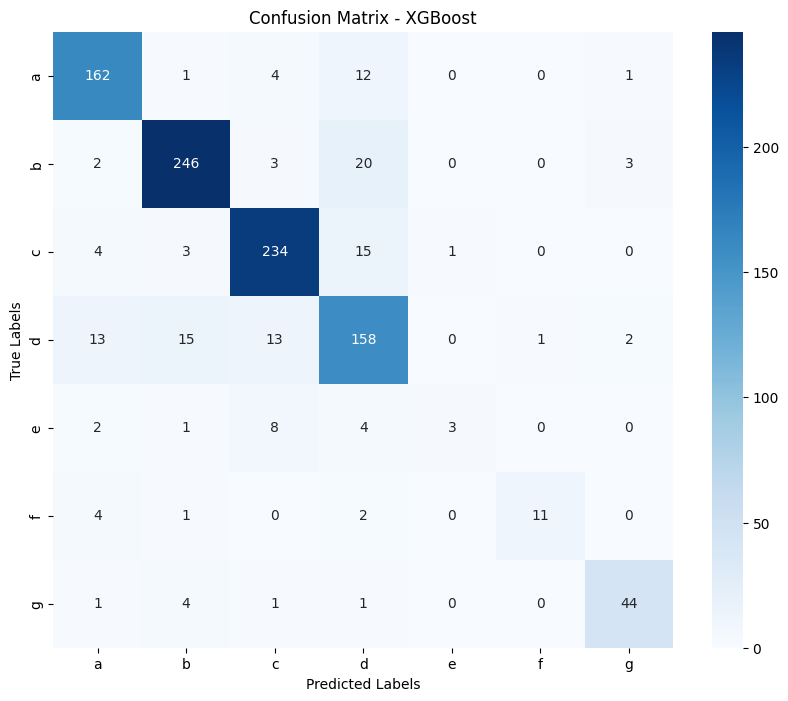

In [35]:
cm = confusion_matrix(y_val_original_xgb, y_pred_xgb_original, labels=le.classes_)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - XGBoost')
plt.show()


#Plot ROC Curves for Multi-class XGBoost Classifier



This code binarizes the true class labels and uses predicted probabilities from the XGBoost model to compute ROC curves and AUC scores for each class. The resulting plot visualizes the trade-off between true positive rate and false positive rate per class, providing insight into classifier performance across all classes.

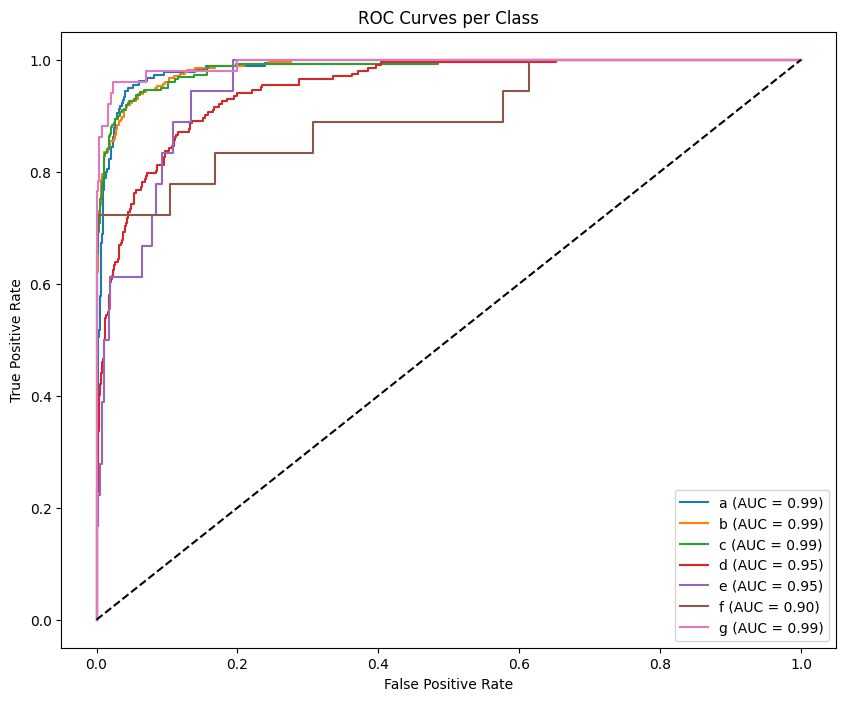

In [36]:
# Binarize labels
y_val_bin = label_binarize(y_val, classes=range(len(le.classes_)))
y_pred_proba = model.predict_proba(X_val)

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend()
plt.show()


#t-SNE Visualization of True vs Predicted Classes


This code uses t-SNE to reduce the high-dimensional embeddings of the validation set to 2D for visualization. It plots two scatter plots side-by-side: one showing the true class labels and the other showing the predicted class labels from the model. This visual comparison helps assess how well the model separates different classes.

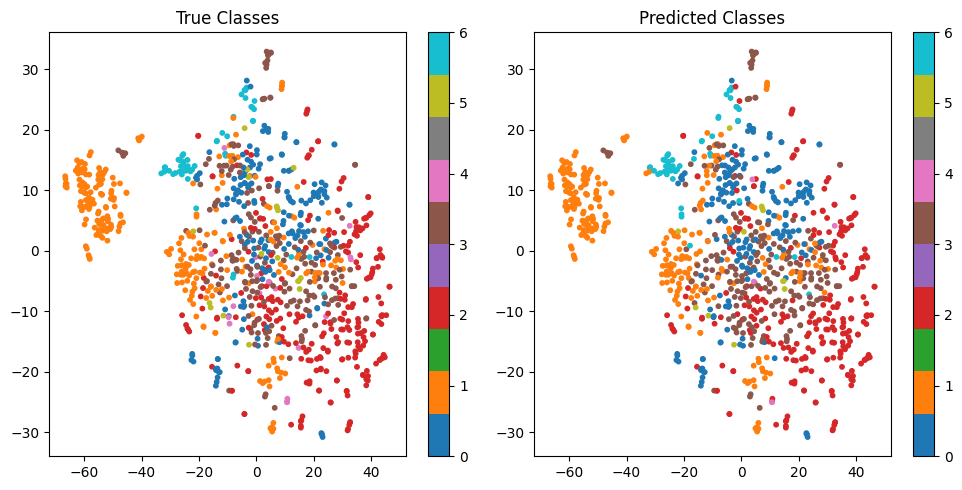

In [37]:
X_val_emb = np.array(X_val)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_val_2d = tsne.fit_transform(X_val_emb)

y_pred = model.predict(X_val)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_val_2d[:, 0], X_val_2d[:, 1], c=y_val, cmap="tab10", s=10)
plt.title("True Classes")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_val_2d[:, 0], X_val_2d[:, 1], c=y_pred, cmap="tab10", s=10)
plt.title("Predicted Classes")
plt.colorbar()

plt.tight_layout()
plt.show()


#Train a Fully Connected Neural Network (MLP) on Protein Embeddings



This section builds and trains a simple Multi-Layer Perceptron (MLP) model with two hidden layers using the protein embeddings as input. The model uses GELU activations, dropout for regularization, and categorical cross-entropy loss with one-hot encoded labels. Early stopping is applied to prevent overfitting by monitoring validation loss.

In [29]:
embedding_dim = X.shape[1]
num_classes = len(le.classes_)

# One-hot encode the labels
lb = LabelBinarizer()
y_train_one_hot = lb.fit_transform(y_train)
y_val_one_hot = lb.transform(y_val)


model = models.Sequential([
    layers.Input(shape=(X.shape[1],)),
    layers.Dense(128, activation='gelu',use_bias=True),
    layers.Dropout(0.1),
    layers.Dense(64, activation='gelu',use_bias=True),
    layers.Dropout(0.1),
    layers.Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
history = model.fit(
    X_train, y_train_one_hot,  # Use one-hot encoded training labels
    validation_data=(X_val, y_val_one_hot), # Use one-hot encoded validation labels
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.1698 - loss: 1.9443 - val_accuracy: 0.4460 - val_loss: 1.5916
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4404 - loss: 1.5283 - val_accuracy: 0.5000 - val_loss: 1.3736
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4953 - loss: 1.3316 - val_accuracy: 0.5350 - val_loss: 1.2306
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5384 - loss: 1.2208 - val_accuracy: 0.5980 - val_loss: 1.1263
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5868 - loss: 1.1214 - val_accuracy: 0.6680 - val_loss: 1.0390
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6105 - loss: 1.0516 - val_accuracy: 0.6810 - val_loss: 0.9720
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6249 - loss: 0.9974 - val_accuracy: 0.6950 - val_loss: 0.9163
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6505 - loss: 0.9462 - val_accuracy: 0.6970 -

#Evaluate the Fully Connected Neural Network



In [30]:
# Evaluate the fully connected model
y_pred_one_hot_fc = model.predict(X_val)
y_pred_fc = lb.inverse_transform(y_pred_one_hot_fc)

# Convert y_val back to original labels for the classification report
y_val_original_fc = le.inverse_transform(y_val)

# Convert predicted labels back to original string labels
y_pred_fc_original = le.inverse_transform(y_pred_fc)

print("Classification Report for Fully Connected Model:")
print(classification_report(y_val_original_fc, y_pred_fc_original, target_names=le.classes_))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report for Fully Connected Model:
              precision    recall  f1-score   support

           a       0.85      0.92      0.88       180
           b       0.93      0.87      0.90       274
           c       0.90      0.91      0.90       257
           d       0.69      0.73      0.71       202
           e       1.00      0.22      0.36        18
           f       1.00      0.61      0.76        18
           g       0.81      0.94      0.87        51

    accuracy                           0.85      1000
   macro avg       0.88      0.74      0.77      1000
weighted avg       0.85      0.85      0.85      1000



In [43]:
df['Class'].unique()

array(['b', 'a', 'c', 'd', 'g', 'e', 'f'], dtype=object)

Although both the fully connected neural network (MLP) and XGBoost classifier achieve comparable performance metrics on our protein classification task, we opted to prioritize XGBoost for practical deployment. XGBoost models tend to have a significantly smaller memory footprint and faster inference times compared to deep neural networks, making them more suitable for environments with limited computational resources. Additionally, XGBoost's robustness to overfitting and ease of interpretability further reinforce its suitability for this application, enabling efficient and reliable predictions without sacrificing accuracy.

#user-friendly web interface for protein family classification

This code implements a user-friendly web interface for protein family classification. It uses pretrained ESM-2 (6-layer) model embeddings to represent input amino acid sequences and a trained XGBoost classifier to predict SCOPe classes labeled as letters ('a' to 'g'). The interface allows users to input protein sequences and receive predicted family classes in real time.

In [ ]:
# Load ESM-2 model (6 layers)
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model.eval()
batch_converter = alphabet.get_batch_converter()

# Load trained XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.load_model("xgb_model_ilyas.json")

# Map numeric class labels to SCOPe letters
label_map = {
    0: 'a',  # All alpha proteins
    1: 'b',  # All beta proteins
    2: 'c',  # Alpha and beta proteins (a/b)
    3: 'd',  # Alpha and beta proteins (a+b)
    4: 'e',  # Multi-domain proteins
    5: 'f',  # Membrane and cell surface proteins and peptides
    6: 'g',  # Small proteins
}

def get_esm2_embedding(sequence):
    sequence = sequence.upper()
    data = [("protein", sequence)]
    labels, strs, tokens = batch_converter(data)
    with torch.no_grad():
        results = model(tokens, repr_layers=[6], return_contacts=False)
    embedding = results["representations"][6][:, 0, :].cpu().numpy()
    return embedding[0]

def predict_class(sequence):
    if not sequence:
        return "Please enter a protein sequence."
    try:
        emb = get_esm2_embedding(sequence)
        emb_reshaped = emb.reshape(1, -1)
        pred_num = xgb_model.predict(emb_reshaped)[0]
        pred_letter = label_map.get(pred_num, "Unknown class")
        return f"Predicted class: {pred_letter}"
    except Exception as e:
        return f"Error: {str(e)}"

iface = gr.Interface(
    fn=predict_class,
    inputs=gr.Textbox(lines=5, placeholder="Enter protein sequence here..."),
    outputs="text",
    title="Protein Family Classification with SuperAI",
    description="Enter an amino acid sequence to get the predicted protein family."
)

if __name__ == "__main__":
    iface.launch()


#Testing Model Robustness on Low Similarity Dataset (40% Identity)



In [45]:

fasta_file = "/content/astral-scopedom-seqres-gd-sel-gs-bib-40-2.08.fa.txt"

for record in SeqIO.parse(fasta_file, "fasta"):


    print("ID:", record.id)
    print("Description:", record.description)
    print("Sequence:", record.seq)
    print("-----")


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
ID: d2bjia_
Description: d2bjia_ e.7.1.1 (A:) automated matches {Cow (Bos taurus) [TaxId: 9913]}
Sequence: dpwqecmdyavtlagqagevvrealknemnimvksspadlvtatdqkvekmlitsikekypshsfigeesvaageksiltdnptwiidpidgttnfvhgfpfvavsigfvvnkkmefgivyscledkmytgrkgkgafcngqklqvshqeditksllvtelgssrtpetvriilsnierllclpihgirgvgtaalnmclvaagaadayyemgihcwdvagagiivteaggvlldvtggpfdlmsrrviassnktlaeriakeiqiiplqrdded
-----
ID: d3biga_
Description: d3biga_ e.7.1.2 (A:) automated matches {Escherichia coli [TaxId: 562]}
Sequence: mrrelaiefsrvtesaalagykwlgrgdkntadgaavnamrimlnqvnidgtivigegeiaeapmlyigekvgtgrgdavdiavdpiegtrmtamgqanalavlavgdkgcflnapdmymeklivgpgakgtidlnlpladnlrnvaaalgkplseltvtilakprhdaviaemqqlgvrvfaipdgdvaasiltcmpdsevdvlygiggapegvvsaaviraldgdmngrllarhdvkgdneenrrigeqelarckamgieagkvlrlgdmarsdnvifsatgitkgdllegisrkgniattetllirgksrtirriqsihyl
-----
ID: d2pcrb_
Description: d2pcrb_ e.7.1.0 (B:) automated matches {Aquifex aeolicus [TaxId: 224324

ID: g1bom.1
Description: g1bom.1 g.1.1.1 (B:,A:) Bombyxin-II {Silkworm (Bombyx mori) [TaxId: 7091]}
Sequence: eqpqavhtycgrhlartladlcweagvdXgivdecclrpcsvdvllsyc

ID: d5olla_
Description: d5olla_ g.3.4.1 (A:) Gurmarin, a sweet taste-suppressing polypeptide {Gymnema sylvestre [TaxId: 4068]}
Sequence: eqcvkkdelcipyyldccepleckkvnwwdhkcig